In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import tensorflow as tf
import cv2
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
sys.path.append('../')
tf.random.set_seed(42)

from helpers import *
#from glash_v2 import glash_discriminator, glash_generator, Glash

2022-02-22 22:39:35.296524: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def glash_discriminator(n=2, act_fun_1=tf.keras.activations.relu):
    """
    Discriminator network side of the GAN. It consists of a sequence of fully connected dense layers that output a
    probability of the input being real (1) or fake (0). It aims to distinguish between real and fake distributions
    (generation samples from the generative network).

    Arguments:
        - n: number of samples it takes as an input in 1D
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n,)),
        tf.keras.layers.Dense(15, activation=act_fun_1,
                              kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(10, activation=act_fun_1,
                              kernel_initializer='he_uniform'),
        #tf.keras.layers.Dense(50, activation=act_fun_1,
        #                     kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name='glash_discriminator')

    return model
    

def glash_generator(latent_dim=5, act_fun_1=tf.keras.activations.relu, act_fun_2=tf.keras.activations.relu):
    """
    Generative network component of the GAN. It consists of a sequence of fully connected dense layers that output a
    newly generated distribution. It aims to generate a distribution that is close to the input distribution improving
    its weights and biases until the discriminator network is no longer able to recognise fake from real data.

    Arguments:
        - latent_dim: number of dimensions of the latent space
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(10, activation=act_fun_1,
                              kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(10, activation=act_fun_1,
                             kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(2, activation=act_fun_2) # Test different activation functions for different shapes
    ], name='glash_generator')

    return model


class Glash(tf.keras.Model):

    def __init__(self, discriminator, generator, latent_dim=5):
        super(Glash, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, optimizerD, optimizerG, loss_fn, loss_fn_2):
        super(Glash, self).compile()
        self.optimizerD = optimizerD
        self.optimizerG = optimizerG
        self.loss_fn = loss_fn
        self.loss_fn_2 = loss_fn_2

    def train_step(self, real_data):
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        # Generate fake data with the appropriate shape and batch size
        batch_size = tf.shape(real_data)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_data = self.generator(noise)

        # Combine real and fake data for training the discriminator
        combined_data = tf.concat([real_data, fake_data], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Training the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_data)
            d_loss = self.loss_fn(labels, predictions)

        # Update the weights of the discriminator
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.optimizerD.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generate fake labels to train the generator
        misleading_labels = tf.ones((batch_size, 1))
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Training the generator
        with tf.GradientTape() as tape:
            fake_predictions = self.discriminator(self.generator(noise))
            g_loss = self.loss_fn_2(misleading_labels, fake_predictions)

        # Update the weights of the generator
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.optimizerG.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss, 'fake_pred': fake_predictions}
    
    def call(self, noise):
        return self.generator(noise)

In [3]:
mean = (1, 1)
cov = [[0, 0], [0, 0]] # Should be symmetric
x = np.random.multivariate_normal(mean, cov, 4000).astype('float32')

(array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0., 

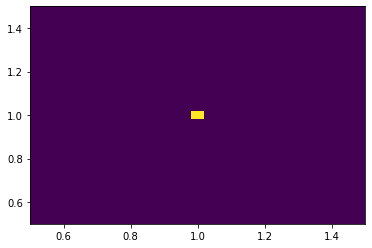

In [4]:
plt.hist2d(x[:, :1].reshape(4000,), x[:, 1:2].reshape(4000,), bins=25)

In [5]:
train_data = tf.data.Dataset.from_tensor_slices(x)
train_data = train_data.batch(32).prefetch(32)

2022-02-22 22:39:50.272692: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-22 22:39:50.374274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-22 22:39:50.622193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 22:39:50.623501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-02-22 22:39:50.623592: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-22 22:39:50.916971: I tensorflow/stream_executor/platform/defa

In [6]:
glash = Glash(glash_discriminator(), glash_generator())
glash.compile(
    tf.keras.optimizers.Adam(),
    tf.keras.optimizers.Adam(),
    tf.keras.losses.BinaryCrossentropy(from_logits=True), # discriminator
    tf.keras.losses.BinaryCrossentropy(from_logits=True)
    #tf.keras.losses.mean_squared_error # generator
)

In [7]:
generated_point_list = []

cbk = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: show_samples(generated_point_list, epoch, glash.generator, x))

history = glash.fit(train_data, epochs=1000, callbacks=[cbk], verbose=False)

2022-02-22 22:39:59.570028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-22 22:39:59.634874: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2022-02-22 22:39:59.978968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


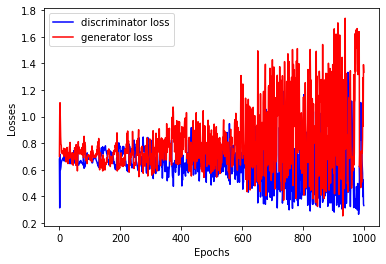

In [8]:
plt.plot(history.history['d_loss'], color='blue', label='discriminator loss')
line = plt.plot(history.history['g_loss'], color='red')
line[0].set_label("generator loss")

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

In [9]:
noise = toy_data(4000, 0, 1).astype('float32')
noise.shape

(4000, 2)

In [10]:
np.random.uniform(0,1,(4000,5))

array([[0.00294768, 0.25379038, 0.12868552, 0.09434648, 0.18247704],
       [0.97587326, 0.66456154, 0.14453769, 0.08478163, 0.77219094],
       [0.57326759, 0.13807459, 0.46336109, 0.36274051, 0.83206471],
       ...,
       [0.06138433, 0.54268853, 0.87363206, 0.74085253, 0.77235458],
       [0.34836425, 0.22865934, 0.31723641, 0.94945973, 0.89979406],
       [0.5278653 , 0.77141335, 0.93335273, 0.85417565, 0.6980536 ]])

(array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0., 

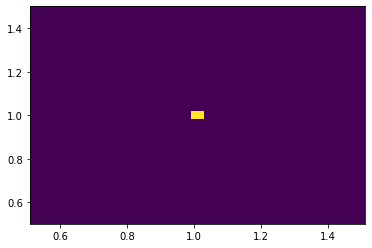

In [11]:
test = glash(np.random.uniform(0,1,(4000,5)))
x_test = tf.reshape(test[:, :1], (4000,))
y_test = tf.reshape(test[:, 1:2], (4000,))

plt.hist2d(x_test, y_test, bins=25)

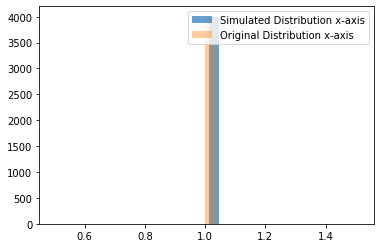

In [12]:
a = x_test.numpy()
plt.hist(a, alpha=0.7, bins=30, label="Simulated Distribution x-axis")
plt.hist(x[:, :1].reshape(4000,), alpha=0.4, bins=30, label="Original Distribution x-axis")
plt.legend()
#print(len(a), len(x[:, :1].reshape(4000,)))

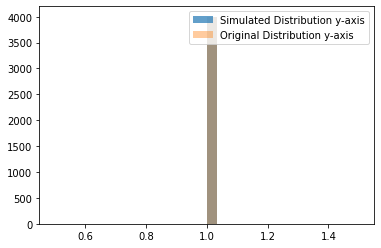

In [13]:
b = y_test.numpy()
plt.hist(b, alpha=0.7, bins=30, label="Simulated Distribution y-axis")
plt.hist(x[:, 1:2].reshape(4000,), alpha=0.4, bins=30, label="Original Distribution y-axis")
plt.legend()
#print(len(b), len(x[:, 1:2].reshape(4000,)))

(array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0., 

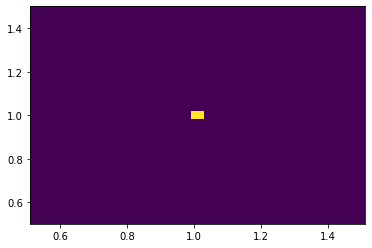

In [14]:
plt.hist2d(a, b, bins=25)

In [15]:
stats_gen_x = stats_dist(a, prnt=False)
stats_gen_y = stats_dist(b, prnt=False)

stats_or_x = stats_dist(x[:, :1].reshape(4000,), prnt=False)
stats_or_y = stats_dist(x[:, 1:2].reshape(4000,), prnt=False)

In [16]:
stats_df = df_generator(stats_or_x,
                        stats_gen_x,
                        stats_or_y,
                        stats_gen_y,
                        np.array(["Mean:", "Standard Deviation:",
                                  " Variance:", "Covariance:"]),
                        df_style)

stats_df

,,original_x_dim,generated_x_dim,original_y_dim,generated_y_dim
0,Mean:,1.000000,1.011277,1.000000,1.000908
1,Standard Deviation:,0.000000,0.000000,0.000000,0.000000
2,Variance:,0.000000,0.000000,0.000000,0.000000
3,Covariance:,0.000000,0.000000,0.000000,0.000000


In [17]:
# OpenCV function that compares 2 histograms, here specifically using the chi_square method to compute the distance
cv2.compareHist(x[:, :1].reshape(4000,), a, cv2.HISTCMP_CHISQR)

0.5087008503323887

0.0


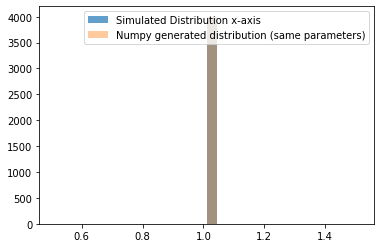

In [18]:
np_sample_1 = np.random.normal(stats_gen_x[0], stats_gen_x[1], 4000).astype("float32")

plt.hist(a, alpha=0.7, bins=30, label="Simulated Distribution x-axis")
plt.hist(np_sample_1, alpha=0.4, bins=30, label="Numpy generated distribution (same parameters)")
plt.legend()

print(cv2.compareHist(a, np_sample_1, cv2.HISTCMP_CHISQR))

4.698530124603476e-10


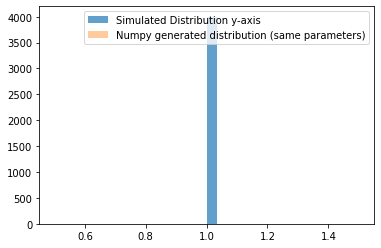

In [19]:
np_sample_2 = np.random.normal(stats_gen_y[0], stats_gen_y[1], 4000).astype("float32")

plt.hist(b, alpha=0.7, bins=30, label="Simulated Distribution y-axis")
plt.hist(np_sample_2, alpha=0.4, bins=30, label="Numpy generated distribution (same parameters)")
plt.legend()

print(cv2.compareHist(b, np_sample_2, cv2.HISTCMP_CHISQR))